<a href="https://colab.research.google.com/github/mwangangibonifaceML/babytorch/blob/master/UCC_coments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings

import math

# Data handling libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tensor handling libraries
import torch
import torch.nn as nn

# transformer handling libraries
import pytorch_lightning as pl
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get to know the dataset

In [ ]:
train_path = '/content/drive/MyDrive/train.csv'
train_ds = pd.read_csv(train_path)


<Axes: >

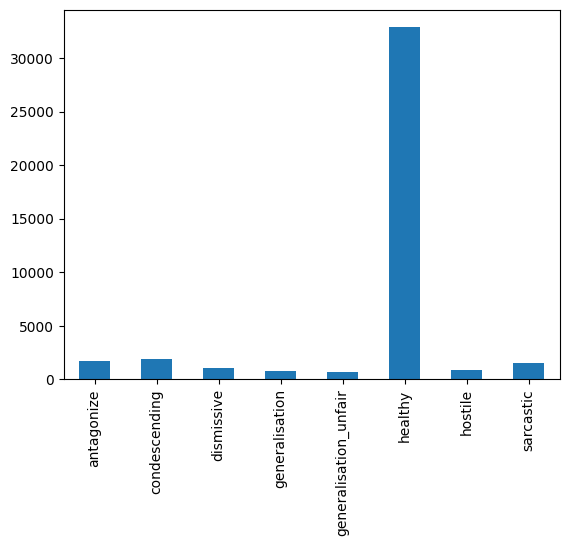

In [ ]:
train_ds.columns
attributes = [
    'antagonize', 'condescending', 'dismissive', 'generalisation', 'generalisation_unfair',
    'healthy', 'hostile', 'sarcastic'
]

train_ds[attributes].sum().plot(kind='bar') # shows imbalnce

In [ ]:
from numpy.random.mtrand import shuffle
# filter the unhealthy and healthy comments
unhealthy_comments = train_ds[train_ds['healthy'] == 0]
healthy_comments = train_ds[train_ds['healthy'] == 1]
print(len(unhealthy_comments), len(healthy_comments))
# undersample the healthy coments
healthy_comments = healthy_comments.sample(n=len(unhealthy_comments), random_state=42)

# concatenate the two to get a balanced dataset
balanced_dataset = pd.concat([healthy_comments, unhealthy_comments])
balanced_dataset['unhealthy'] = np.where(balanced_dataset['healthy'] == 0, 1, 0)
# balanced_dataset = balanced_dataset.sample(frac=1

2655 32848


<Axes: >

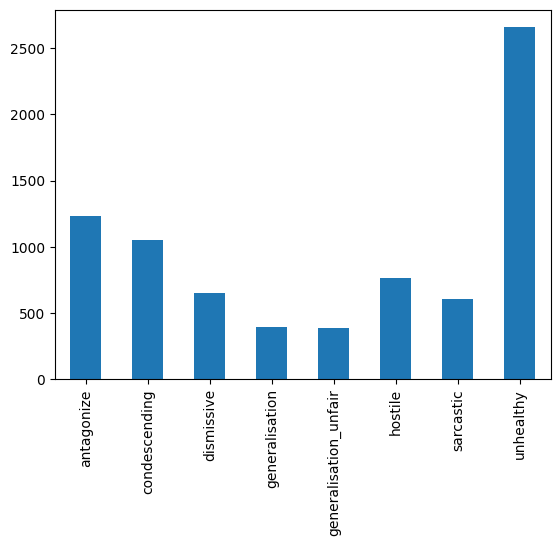

In [ ]:
attributes.remove('healthy')
attributes.append('unhealthy')
balanced_dataset[attributes].sum().plot(kind='bar')

Create a pytorch Dataset

In [ ]:
class UCC_Comment_Dataset(Dataset):

    def __init__(
            self,
            dataset_path: str,
            attributes: list,
            tokenizer: AutoTokenizer,
            sample: int | None = 5000,
            max_tokens: int = 128):
        super().__init__()
        self.data_path = dataset_path
        self.sample = sample
        self.attributes = attributes
        self.tokenizer = tokenizer
        self.max_tokens = max_tokens
        self._prepare_data()

    def _prepare_data(self):
        data = pd.read_csv(self.data_path)
        data['unhealthy'] = np.where(data['healthy'] == 1,0,1)

        # Ensure 'comment' column is string type and fill NaN values
        data['comment'] = data['comment'].astype(str).fillna('')

        if self.sample is not None:
            unhealthy_comments = data.loc[data[self.attributes].sum(axis=1) > 0]
            healthy_comments = data.loc[data[self.attributes].sum(axis=1) == 0]
            healthy_comments = healthy_comments.sample(n=self.sample, random_state=42)
            data = pd.concat([unhealthy_comments, healthy_comments.sample(n=self.sample)])
            self.data = data
        else:
            self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]
        comment = item['comment']
        labels = torch.tensor(item[self.attributes])
        tokens = self.tokenizer(
                        comment, return_tensors='pt',
                        add_special_tokens=True,
                        truncate=True,
                        max_length= self.max_tokens,
                        padding='max_length',
                        return_attention_mask=True)
        return {
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'labels': labels
        }

Create a DataLoader

In [ ]:
class UCC_Coment_DataModule(pl.LightningDataModule):

    def __init__(
            self,
            train_path: str,
            val_path: str,
            attributes: list,
            tokenizer: AutoTokenizer,
            sample: int | None = None,
            max_tokens: int = 128,
            num_workers: int = 2,
            batch_size: int = 32) -> None:
            super().__init__()
            self.train_path = train_path
            self.val_path = val_path
            self.attributes = attributes
            self.max_tokens = max_tokens
            self.tokenizer = tokenizer
            self.num_workers = num_workers
            self.batch_size = batch_size
            # self.sample = sample

    def set_up(self, stage: str | None= None):
        if stage == 'fit' or stage is None:
            self.train_dataset = UCC_Comment_Dataset(dataset_path=self.train_path,attributes=self.attributes,
                                                    tokenizer=self.tokenizer)
            self.val_dataset = UCC_Comment_Dataset(dataset_path=self.val_path,sample=None,attributes=self.attributes,
                                                   tokenizer=self.tokenizer)
        elif stage == 'predict':
            self.val_dataset = UCC_Comment_Dataset(dataset_path=self.val_path,sample=None,attributes=self.attributes,
                                                    tokenizer=self.tokenizer)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, drop_last=True)

In [ ]:
model_checkpoint = 'distilroberta-base'
auto_model = AutoModel.from_pretrained(model_checkpoint, return_dict=True)
auto_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: distilroberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Create the model

In [ ]:
class UCC_Comment_Classifier(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(self.config['model_checkpoint'], return_dict=True)

        # create new layers for classification
        self.hidden_layer = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['num_labels'])
        self.dropout = nn.Dropout(self.config['dropout'])

        # initialize the layers
        torch.nn.init.xavier_normal(self.hidden_layer.weight)
        torch.nn.init.xavier_normal(self.classifier.weight)

        # get the loss function
        self.loss_fn = nn.BCEWithLogitsLoss(reduction='mean') # Corrected 'means' to 'mean'

    def forward(self, input_ids, attention_mask, labels: None):
        output = self.pretrained_model(input_ids, attention_mask)
        pooled_output = torch.mean(output.last_hidden_state,1)
        logits = self.classifier(self.dropout(self.hidden_layer(pooled_output)))

        if labels is not None:
            loss = self.loss_fn(logits.view(-1, self.config['num_labels']), labels.view(-1, self.config['num_labels']))
        return loss, logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, logits = self(input_ids, attention_mask, labels)
        self.log('train_loss',loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'prediction': logits, 'labels': labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, logits = self(input_ids, attention_mask, labels)
        self.log('train_loss',loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss, 'prediction': logits, 'labels': labels}

    def predict_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        _, logits = self(input_ids, attention_mask, labels)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['lr'], weight_decay= self.config['weight_decay'])
        total_steps = self.config['train_size'] / self.config['batch_size']
        warmup_steps = math.floor(total_steps / self.config['warmup_steps'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]

In [ ]:
UCC_comments_config = {
    'model_checkpoint': 'distilroberta-base',
    'num_labels': len(attributes),
    'lr': 1e-5,
    'weight_decay': 1e-2,
    'dropout': 0.1,
    'warmup_steps': 0.1,
    'batch_size': 16,
    'train_size': len(train_ds),
    'max_epochs':10,

}

ucc_comment_classifier = UCC_Comment_Classifier(UCC_comments_config)


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: distilroberta-base
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
attributes = [
    'antagonize', 'condescending', 'dismissive', 'generalisation', 'generalisation_unfair',
     'hostile', 'sarcastic'
]

ucc_data_module = UCC_Coment_DataModule(
                                train_path=train_path,
                                val_path=train_path,
                                attributes=attributes,
                                tokenizer=auto_tokenizer,
                                batch_size=16)
ucc_data_module.set_up()

trainer = pl.Trainer(
    max_epochs=UCC_comments_config['max_epochs'],
    accelerator='cuda',
    devices=1,
    precision=16,
    num_sanity_val_steps=50)
trainer.fit(model=ucc_comment_classifier, datamodule=ucc_data_module )

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ pretrained_model │ RobertaModel      │ 82.1 M │ eval  │     0 │
│ 1 │ hidden_layer     │ Linear            │  590 K │ train │     0 │
│ 2 │ classifier       │ Linear            │  5.4 K │ train │     0 │
│ 3 │ dropout          │ Dropout           │      0 │ train │     0 │
│ 4 │ loss_fn          │ BCEWithLogitsLoss │      0 │ train │     0 │
└───┴──────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 82.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 82.7 M                                                                                               
Total estimated model params size (MB): 330                                                                        
Modules in train mode: 4                                                                                           
Modules in eval mode: 120                                                                                          
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1079, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1123, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 217, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 465, in advance
    self.epoch_loop.run(self._data_fetcher)
  File

TypeError: object of type 'NoneType' has no len()

In [ ]:
help(pl.Trainer.fit)

Help on function fit in module pytorch_lightning.trainer.trainer:

fit(self, model: 'pl.LightningModule', train_dataloaders: Union[Any, pytorch_lightning.core.datamodule.LightningDataModule, NoneType] = None, val_dataloaders: Optional[Any] = None, datamodule: Optional[pytorch_lightning.core.datamodule.LightningDataModule] = None, ckpt_path: Union[str, pathlib.Path, NoneType] = None, weights_only: Optional[bool] = None) -> None
    Runs the full optimization routine.

    Args:
        model: Model to fit.

        train_dataloaders: An iterable or collection of iterables specifying training samples.
            Alternatively, a :class:`~pytorch_lightning.core.datamodule.LightningDataModule` that defines
            the :class:`~pytorch_lightning.core.hooks.DataHooks.train_dataloader` hook.

        val_dataloaders: An iterable or collection of iterables specifying validation samples.

        datamodule: A :class:`~pytorch_lightning.core.datamodule.LightningDataModule` that defines
   